Imported FourJointRobot


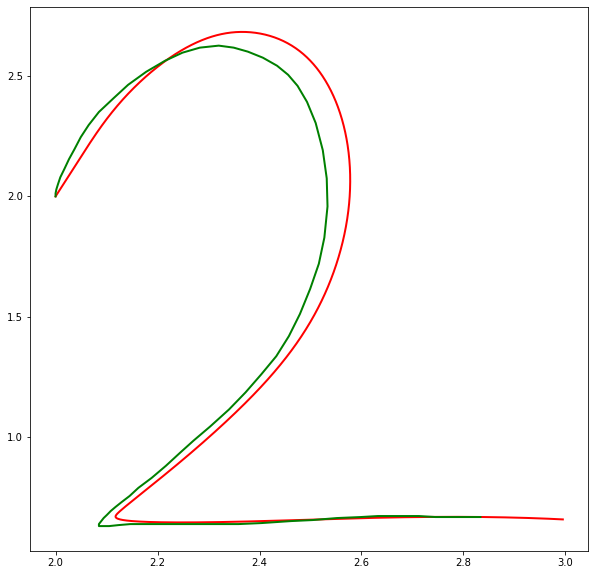

In [1]:
import pybullet as b
import time
import pybullet_data
import eigen as e
import rbdyn as rbd
import sva as s
import numpy as np
from rbdyn.parsers import *

import matplotlib.pyplot as plt
import dmp_pkg.dmp_discrete

DT = 0.001 #s
MOVEMENT_TIME = 10#10000 #ms
DMP_ERR_GAIN = 500

def body_id_from_name(name, bodies):
    '''Gets the body Id from the body name
    @param name The name of the body
    @param bodies The set of bodies provided by the multibody data structure
    @return Id of the body, -1 if not found
    '''
    for bi, b in enumerate(bodies):
        if (b.name().decode("utf-8") == name):
            return bi
    return -1

def sva_to_affine(s):
    '''Converts a spatial transform matrix to a homogeneous transform matrix
    @param s Spatial transform
    @return Homogeneous transform matrix
    '''
    m4d = e.Matrix4d.Identity()
    R = s.rotation().transpose()
    p = s.translation()
    
    for row in range(3):
        for col in range(3):
            m4d.coeff(row, col, R.coeff(row, col))
    for row in range(3):
        m4d.coeff(row, 3, p[row])
        
    return m4d

def inv_spd_sr(mat, k=1e-4):
    '''Converts an inverse into an SVD problem with singularity robust inverse
    @param mat Matrix to be inversed
    @param tolerance Tolerance to the minimum singular value that can go through reciprocal operation
    @return Homogeneous transform matrix
    '''
    mat_np = np.array(mat)
    reg = k * np.identity(np.size(mat_np,0))
    
    return e.MatrixXd(mat_np.transpose().dot(np.linalg.inv(mat_np.dot(mat_np.transpose()) + reg)))

# import robot as global variable
p = from_urdf_file("./resource/four_dof.urdf")
print("Imported " + p.name.decode("utf-8"))
# set gravity direction (this is the acceleration at base joint for RNEA)
p.mbc.gravity = e.Vector3d(0,0,9.81)
p.mbc.zero(p.mb)

# setup physics
physicsClient = b.connect(b.GUI)
b.setAdditionalSearchPath(pybullet_data.getDataPath()) #used by loadURDF
b.setGravity(0,0,-9.81)
b.setRealTimeSimulation(0)
b.setTimeStep(DT)

# import robot
planeId = b.loadURDF("plane.urdf")
startPos = [0,0,1]
startOrientation = b.getQuaternionFromEuler([0,0,0])
loadFlag = b.URDF_USE_INERTIA_FROM_FILE | b.URDF_USE_SELF_COLLISION_EXCLUDE_ALL_PARENTS
robotId = b.loadURDF("./resource/four_dof.urdf",startPos, startOrientation, flags=loadFlag)
nDof = b.getNumJoints(robotId)
jointsId = range(nDof)

# setup visualizer
b.resetDebugVisualizerCamera(cameraDistance=3.0, cameraYaw=0.0, cameraPitch=0.0, cameraTargetPosition=startPos)
b.configureDebugVisualizer(b.COV_ENABLE_GUI,0)

# setup configuration
b.setJointMotorControlArray(robotId, jointsId, b.VELOCITY_CONTROL, forces=[0] * nDof)
q_home = [0.6524786685190415, -0.7891557752882681, 0.8792139557391727, 1.3774730897711231]
for i in jointsId:
    b.resetJointState(robotId, i, targetValue=q_home[i])
    
# dmp
y_des = np.load("./resource/2.npz")["arr_0"].T
y_des -= y_des[:, 0][:, None]
y_des_offset = np.ones_like(y_des)
y_des_offset[0] *= 2
y_des_offset[1] *= 2
y_des += y_des_offset
dmp = dmp_pkg.dmp_discrete.DMPs_discrete(n_dmps=2, n_bfs=500, ay=np.ones(2) * 10.0)
y_track = []
dy_track = []
ddy_track = []
y_interp = dmp.imitate_path(y_des=y_des)
dmp.reset()
error_norm = 0

# data
y_actual = []
err_actual = []

# simulate torque control
for i in range(2000):
    joint_states = b.getJointStates(robotId, jointsId)
    
    # read state feedback
    q = [joint_states[i][0] for i in jointsId]
    dq = [joint_states[i][1] for i in jointsId]
    
    # update state in model
    p.mbc.q = [[], [q[0]], [q[1]], [q[2]], [q[3]]]
    p.mbc.alpha = [[], [dq[0]], [dq[1]], [dq[2]], [dq[3]]]

    # forward kinematics
    rbd.forwardKinematics(p.mb, p.mbc)
    rbd.forwardVelocity(p.mb, p.mbc)
    
    # convert
    q = e.VectorXd(q)
    dq = e.VectorXd(dq)
    
    # pose
    ofsRot = e.Matrix3d.Identity()
    ofsPos = e.Vector3d(1,0,0)
    T1 = sva_to_affine(s.PTransformd(ofsRot.transpose(), ofsPos) * p.mbc.bodyPosW[body_id_from_name("link_4", p.mb.bodies())])
    T2 = sva_to_affine(s.PTransformd(ofsRot.transpose(), ofsPos) * p.mbc.bodyPosW[body_id_from_name("link_2", p.mb.bodies())])
    
    # select xz coordinates
    S = e.MatrixXd.Zero(2,6)
    S.coeff(0,3,1)
    S.coeff(1,5,1)
    
    # jacobian, dJacobian [angular; linear]
    bodyName = "link_4"
    jac = rbd.Jacobian(p.mb, bodyName.encode('utf-8'), ofsPos)
    tempJ1 = e.MatrixXd(6, p.mb.nrDof())
    tempdJ1 = e.MatrixXd(6, p.mb.nrDof())
    jac.fullJacobian(p.mb, jac.jacobian(p.mb, p.mbc), tempJ1)
    jac.fullJacobian(p.mb, jac.jacobianDot(p.mb, p.mbc), tempdJ1)
    J1 = S*tempJ1
    dJ1 = S*tempdJ1
    
    # jacobian, dJacobian [angular; linear]
    bodyName = "link_2"
    jac = rbd.Jacobian(p.mb, bodyName.encode('utf-8'), ofsPos)
    tempJ2 = e.MatrixXd(6, p.mb.nrDof())
    tempdJ2 = e.MatrixXd(6, p.mb.nrDof())
    jac.fullJacobian(p.mb, jac.jacobian(p.mb, p.mbc), tempJ2)
    jac.fullJacobian(p.mb, jac.jacobianDot(p.mb, p.mbc), tempdJ2)
    J2 = S*tempJ2
    dJ2 = S*tempdJ2
    
    # mass matrix
    fd = rbd.ForwardDynamics(p.mb)
    fd.computeH(p.mb, p.mbc)
    M = fd.H()

    # nonlinear effects
    fd = rbd.ForwardDynamics(p.mb)
    fd.computeC(p.mb, p.mbc)
    h = fd.C()
    
    # compute Minv
    Minv = M.inverse()
    
    # compute lambda1, Jbar1, Nprec1
    lambda1 = inv_spd_sr(J1*Minv*J1.transpose(),1e-3)
    J1bar = Minv*J1.transpose()*lambda1
    Nprec1 = e.MatrixXd.Identity(nDof, nDof) - J1bar*J1
    
    # compute lambda21, Jbar21
    J21 = J2*Nprec1
    lambda21 = inv_spd_sr(J21*Minv*J21.transpose(),1e-3)
    J21bar = Minv*J21.transpose()*lambda21
    Nprec2 = Nprec1 * (e.MatrixXd.Identity(nDof, nDof) - J21bar*J21)

    # dmp rollout
    p_des, _, _ = dmp.step(tau=1.0, L2_error=DMP_ERR_GAIN*error_norm)
    x_des = p_des
    err = np.array([T1.coeff(0,3)-x_des[0], T1.coeff(2,3)-x_des[1]])
    error_norm = np.linalg.norm(err)
    y_actual.append(np.array([T1.coeff(0,3),T1.coeff(2,3)]))
    err_actual.append(err)
    x1des = x_des[0]
    z1des = x_des[1]
    x2des = 1.5
    z2des = 1
    
    # error
    err1 = e.VectorXd(2)
    err1[0] = x1des - T1.coeff(0,3)
    err1[1] = z1des - T1.coeff(2,3)
    derr1 = -J1*dq
    err2 = e.VectorXd(2)
    err2[0] = x2des - T2.coeff(0,3)
    err2[1] = z2des - T2.coeff(2,3)
    derr2 = -J2*dq

    # control
    tau_1 = e.VectorXd(J1.transpose()*lambda1*(400*err1+40*derr1-dJ1*dq))
    tau_2 = e.VectorXd(J21.transpose()*lambda21*(400*err2+40*derr2-dJ2*dq-J2*Minv*tau_1))
    tau = tau_1 + Nprec1.transpose()*tau_2 + h

    # command system:
    for i in jointsId:
        b.setJointMotorControl2(robotId, i, b.TORQUE_CONTROL, force=tau[i])
    
    b.stepSimulation()
    time.sleep(DT)
b.disconnect()

y_actual = np.array(y_actual)
plt.figure(1, figsize=(10, 10))
plt.plot(y_actual[:, 0], y_actual[:, 1], "r", lw=2, label="actual")
plt.plot(y_interp[0, :], y_interp[1, :], "g", lw=2, label="interpolated")
plt.show()